<a href="https://colab.research.google.com/github/Sathwick-Reddy-M/550-Research-Paper/blob/main/Research_Paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import re

In [2]:
%cd "/content/drive/MyDrive/550/Research Paper/fnc-1/"

/content/drive/MyDrive/550/Research Paper/fnc-1


# Dataset Analysis

In [3]:
# Load the data

train_bodies = pd.read_csv('train_bodies.csv')
train_stances = pd.read_csv('train_stances.csv')

In [4]:
merged_data = pd.merge(train_stances, train_bodies, on='Body ID')

## Row Counts and Values

In [ ]:
train_bodies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1683 entries, 0 to 1682
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Body ID      1683 non-null   int64 
 1   articleBody  1683 non-null   object
dtypes: int64(1), object(1)
memory usage: 26.4+ KB


It has 1683 article bodies

In [ ]:
train_stances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49972 entries, 0 to 49971
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Headline  49972 non-null  object
 1   Body ID   49972 non-null  int64 
 2   Stance    49972 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49972 entries, 0 to 49971
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Headline     49972 non-null  object
 1   Body ID      49972 non-null  int64 
 2   Stance       49972 non-null  object
 3   articleBody  49972 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.5+ MB


In [ ]:
# Find the number of distinct Headline and BodyID
num_distinct_headlines = merged_data['Headline'].nunique()
num_distinct_body_ids = merged_data['Body ID'].nunique()

# Print the results
print("Number of distinct Headlines:", num_distinct_headlines)
print("Number of distinct Body IDs:", num_distinct_body_ids)

Number of distinct Headlines: 1648
Number of distinct Body IDs: 1683


In [ ]:
# Calculate the distribution of stance classes
stance_counts = merged_data['Stance'].value_counts()
stance_distribution = stance_counts / stance_counts.sum()

# Combine original counts and normalized counts into a DataFrame
distribution_df = pd.concat([stance_counts, stance_distribution], axis=1)
distribution_df.columns = ['Original Counts', 'Normalized Counts']

# Print the distribution
print("Stance Distribution:")
print(distribution_df)

Stance Distribution:
           Original Counts  Normalized Counts
Stance                                       
unrelated            36545           0.731310
discuss               8909           0.178280
agree                 3678           0.073601
disagree               840           0.016809


In [ ]:
# Define a regex pattern to match any character that is not a letter or whitespace
pattern = r'[^a-zA-Z\s]'

# Filter the dataframe to get distinct headlines that match the pattern
distinct_headlines_with_numbers_or_special_chars = merged_data[merged_data['Headline'].str.contains(pattern)]['Headline'].unique()

# Print the distinct headlines
print("Distinct Headlines containing numbers or special characters:")
print(distinct_headlines_with_numbers_or_special_chars)

Distinct Headlines containing numbers or special characters:
["Police find mass graves with at least '15 bodies' near Mexico town where 43 students disappeared after police clash"
 'Seth Rogen to Play Apple’s Steve Wozniak'
 'Mexico police find mass grave near site 43 students vanished' ...
 'Apple is limiting features on the Apple Watch to save battery life, according to developers'
 'Mom Calls 911 On Masturbating Teenage Son; Boy Arrested, Charged With New ‘Self-Rape’ State Law'
 "Sushi lover's entire body left riddled with WORMS after eating contaminated sashimi"]


In [ ]:
# Define a regex pattern to match any character that is not a letter or whitespace
pattern = r'[^a-zA-Z\s]'

# Filter the dataframe to get distinct bodies that match the pattern
distinct_bodies_with_numbers_or_special_chars = merged_data[merged_data['articleBody'].str.contains(pattern)]['articleBody'].unique()

# Print the distinct bodies
print("Distinct Bodies containing numbers or special characters:")
print(distinct_bodies_with_numbers_or_special_chars)

Distinct Bodies containing numbers or special characters:
['Danny Boyle is directing the untitled film\r\n\r\nSeth Rogen is being eyed to play Apple co-founder Steve Wozniak in Sony’s Steve Jobs biopic.\r\n\r\nDanny Boyle is directing the untitled film, based on Walter Isaacson\'s book and adapted by Aaron Sorkin, which is one of the most anticipated biopics in recent years.\r\n\r\nNegotiations have not yet begun, and it’s not even clear if Rogen has an official offer, but the producers — Scott Rudin, Guymon Casady and Mark Gordon — have set their sights on the talent and are in talks.\r\n\r\nOf course, this may all be for naught as Christian Bale, the actor who is to play Jobs, is still in the midst of closing his deal. Sources say that dealmaking process is in a sensitive stage.\r\n\r\nInsiders say Boyle will is flying to Los Angeles to meet with actress to play one of the female leads, an assistant to Jobs. Insiders say that Jessica Chastain is one of the actresses on the meeting li

In [ ]:
len(distinct_bodies_with_numbers_or_special_chars)

1666

It's better not remove the digits because they hold the meaning some of the headlines. But we can just ignore the special characters anyway because they don't help much in the identification of the relation between the headline and body

## Analysing the Merged Data

In [35]:
merged_data.head()

,Headline,Body ID,Stance,articleBody
0,Police find mass graves with at least '15 bodi...,712,unrelated,Danny Boyle is directing the untitled film\r\n...
1,Seth Rogen to Play Apple’s Steve Wozniak,712,discuss,Danny Boyle is directing the untitled film\r\n...
2,Mexico police find mass grave near site 43 stu...,712,unrelated,Danny Boyle is directing the untitled film\r\n...
3,Mexico Says Missing Students Not Found In Firs...,712,unrelated,Danny Boyle is directing the untitled film\r\n...
4,New iOS 8 bug can delete all of your iCloud do...,712,unrelated,Danny Boyle is directing the untitled film\r\n...


### Body ID

Distribution of Articles Across Body IDs:
count    1683.000000
mean       29.692216
std        28.705800
min         1.000000
25%         8.000000
50%        21.000000
75%        42.500000
max       187.000000
Name: count, dtype: float64

Body IDs with the Highest Number of Associated Articles:
Body ID: 1921, Number of Articles: 187

Body IDs with the Lowest Number of Associated Articles:
Body ID: 200, Number of Articles: 1
Body ID: 283, Number of Articles: 1
Body ID: 232, Number of Articles: 1
Body ID: 323, Number of Articles: 1
Body ID: 370, Number of Articles: 1
Body ID: 18, Number of Articles: 1
Body ID: 228, Number of Articles: 1
Body ID: 282, Number of Articles: 1
Body ID: 151, Number of Articles: 1
Body ID: 112, Number of Articles: 1
Body ID: 136, Number of Articles: 1
Body ID: 982, Number of Articles: 1
Body ID: 2079, Number of Articles: 1
Body ID: 476, Number of Articles: 1
Body ID: 797, Number of Articles: 1
Body ID: 407, Number of Articles: 1
Body ID: 915, Number of Articles

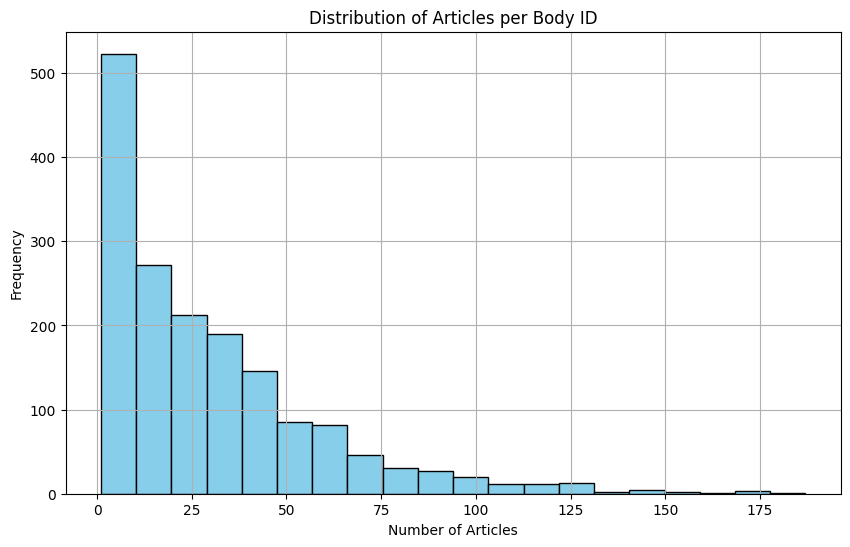

In [47]:
import matplotlib.pyplot as plt

# Calculate the number of articles associated with each Body ID
articles_per_body_id = merged_data['Body ID'].value_counts()

# Find the maximum and minimum number of articles
max_articles_count = articles_per_body_id.max()
min_articles_count = articles_per_body_id.min()

# Find Body IDs with the maximum and minimum number of articles
max_articles_body_ids = articles_per_body_id[articles_per_body_id == max_articles_count]
min_articles_body_ids = articles_per_body_id[articles_per_body_id == min_articles_count]

# Print Body IDs with the maximum number of articles
print("\nBody IDs with the Highest Number of Associated Articles:")
for body_id, count in max_articles_body_ids.items():
    print(f"Body ID: {body_id}, Number of Articles: {count}")

# Print Body IDs with the minimum number of articles
print("\nBody IDs with the Lowest Number of Associated Articles:")
for body_id, count in min_articles_body_ids.items():
    print(f"Body ID: {body_id}, Number of Articles: {count}")


# Plot the Distribution of the Number of Articles per Body ID
plt.figure(figsize=(10, 6))
articles_per_body_id.plot(kind='hist', bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Number of Articles')
plt.ylabel('Frequency')
plt.title('Distribution of Articles per Body ID')
plt.grid(True)
plt.show()


In [9]:
merged_data['Body ID'].value_counts()

Body ID
1921    187
1948    175
40      172
524     171
1549    166
       ... 
16        1
65        1
114       1
24        1
1066      1
Name: count, Length: 1683, dtype: int64

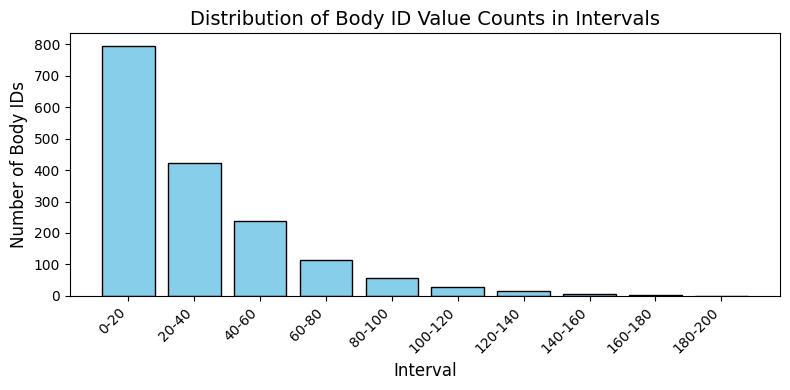

In [38]:
# X-Axis - Range for Value Counts Y-Axis - Number of Body_ids (count) fall in that range

import matplotlib.pyplot as plt

# Define intervals for value counts
interval_size = 20
max_count = merged_data['Body ID'].value_counts().max()
num_intervals = max_count // interval_size + 1
intervals = [(i * interval_size, (i + 1) * interval_size) for i in range(num_intervals)]

# Count how many Body IDs fall into each interval
body_id_counts = merged_data['Body ID'].value_counts()
counts_in_intervals = [((body_id_counts >= interval[0]) & (body_id_counts < interval[1])).sum() for interval in intervals]

# Plot the distribution of Body ID counts in intervals
plt.figure(figsize=(8, 4))  # Set smaller figure size here
plt.bar(range(num_intervals), counts_in_intervals, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Interval', fontsize=12)
plt.ylabel('Number of Body IDs', fontsize=12)
plt.title('Distribution of Body ID Value Counts in Intervals', fontsize=14)
plt.xticks(range(num_intervals), [f'{interval[0]}-{interval[1]}' for interval in intervals], rotation=45, ha='right')

# Show plot
plt.tight_layout()
plt.show()


In [39]:
counts_in_intervals

[795, 421, 239, 114, 57, 29, 16, 7, 4, 1]

### Stance

In [20]:
merged_data.groupby('Stance').size()

Stance
agree         3678
disagree       840
discuss       8909
unrelated    36545
dtype: int64

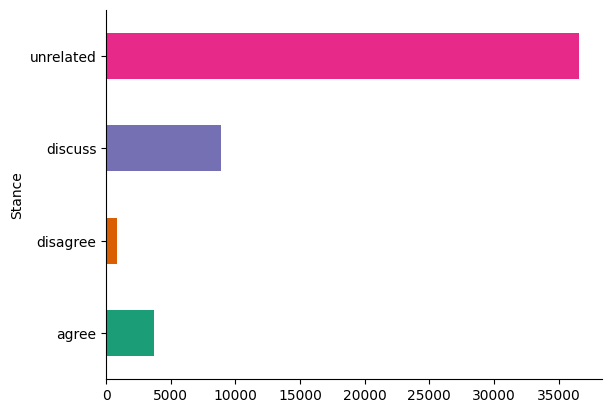

In [21]:
from matplotlib import pyplot as plt
import seaborn as sns
merged_data.groupby('Stance').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)